# Rice Shape and Chalkiness Analysis Workflow

This full workflow shows how to analyze the shape and chalkiness of an individual grain of rice, and should work for similarly imaged grains. For images with multiple grains, analysis functions from this workflow can be combined with methods for analyzing multiple objects in an image from the Arabidopsis Multi-plant Tutorial 

# Section 1: Importing libraries and image

In [21]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [22]:
# Import libraries
import argparse
import posixpath
import numpy as np
import cv2
from plantcv import plantcv as pcv
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"] = [10, 10]

## Input variables
The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [1]:
# Input image into self.image (include file path if image is not in 
# the same folder as jupyter notebook)

# Set self.debug to "plot" so that image outputs for each step is shown
# once cell is run in jupyter notebooks (recommended)

class options:
    def __init__(self):        
        self.image = "./img/rice.png"
        self.debug = "plot"
        self.writeimg = False
        self.result = "rice_analysis_results"
        self.outdir = "."

In [24]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

## Read the input image

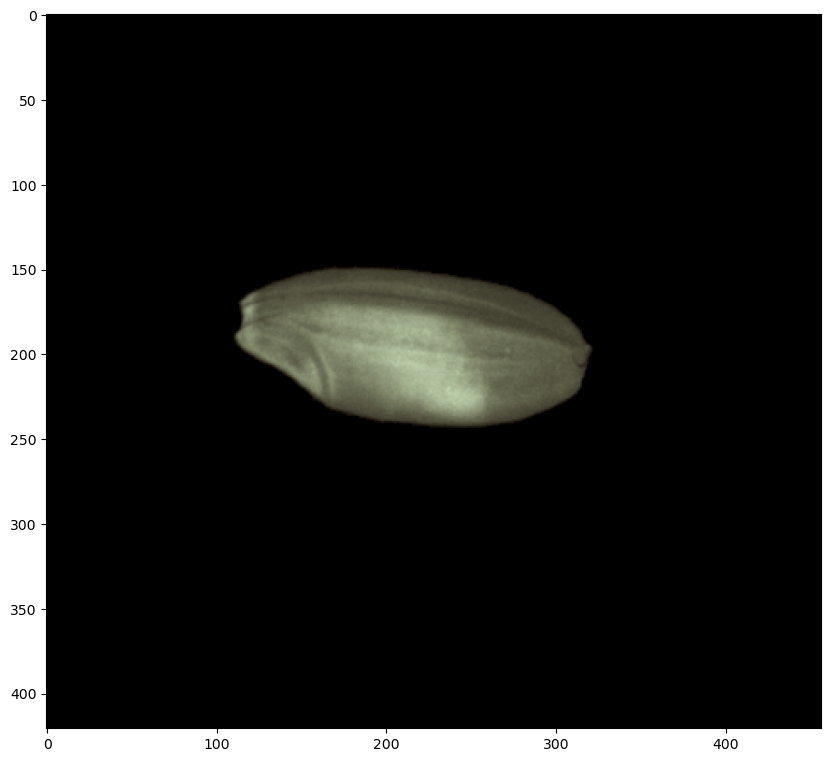

In [25]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, imgpath, imgname = pcv.readimage(filename=args.image)

## Section 2: Segmenting plant from background and identifying plant object(s)
* Requires successful import of image
* See the Tools for Thresholding Plant Data tutorial for other functions that can be used to create a binary mask

## Visualize colorspaces
The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

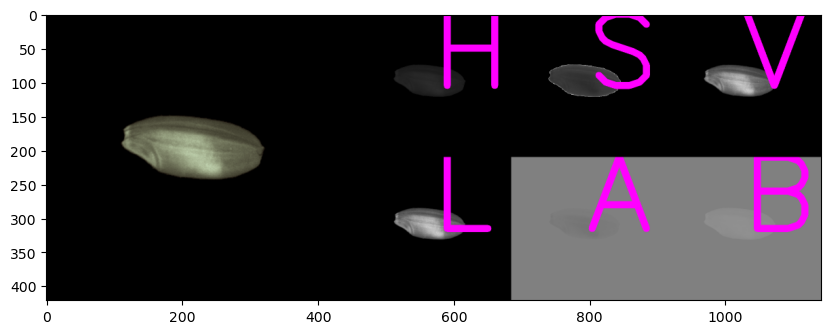

In [26]:
# Inputs:
#   rbg_img      = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspace_img = pcv.visualize.colorspaces(rgb_img=img)

## Convert the color image to grayscale¶
Converts the input color image into the LAB colorspace and returns the L (lightness) channel as a grayscale image.

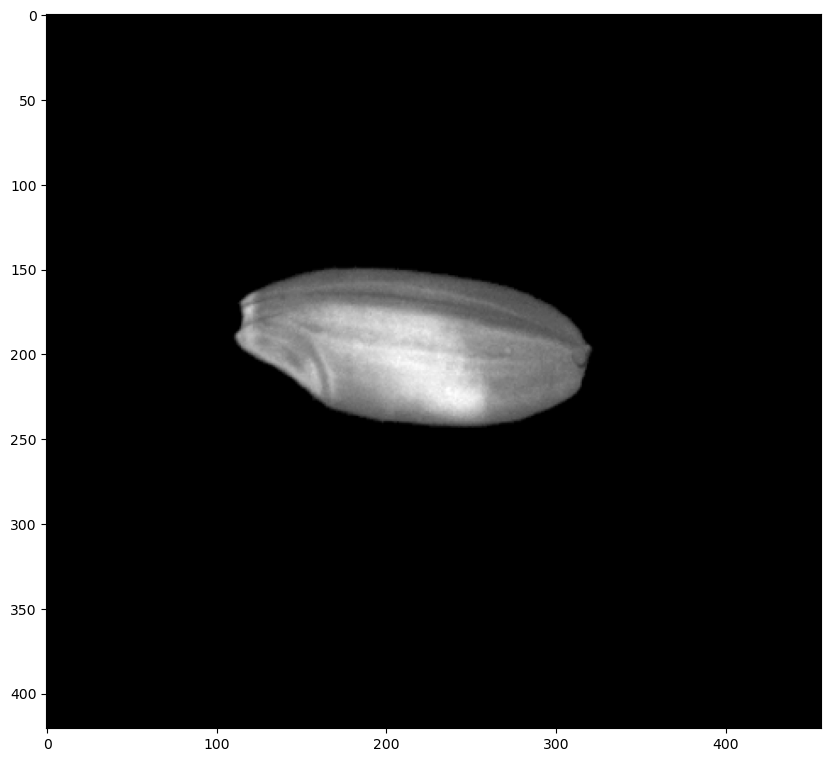

In [27]:
# Inputs:
#   rbg_img - original image
#   channel - desired colorspace ('l', 'a', or 'b')
l = pcv.rgb2gray_lab(rgb_img=img, channel='l')

## Visualize the distribution of grayscale values
A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between close to 0 are from the darker background pixels. The smaller peak between 60-80 are the lighter grain pixels.

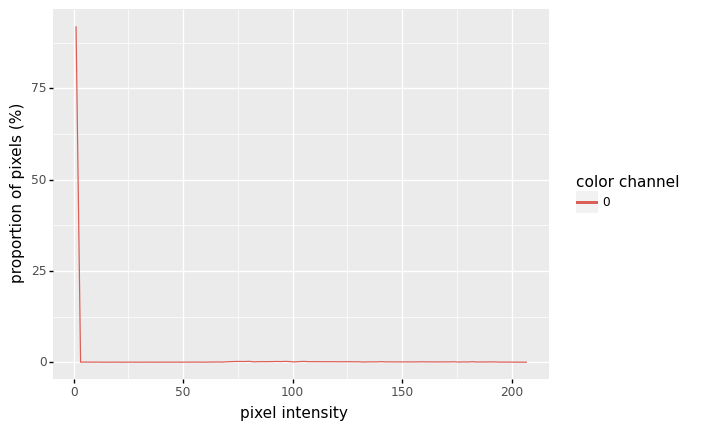

In [31]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=l)

## Threshold the grayscale image
Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 30-40 will segment the plant and background peaks. Because the seeds are the lighter pixels in this image, use object_type="light" to do a traditional threshold.

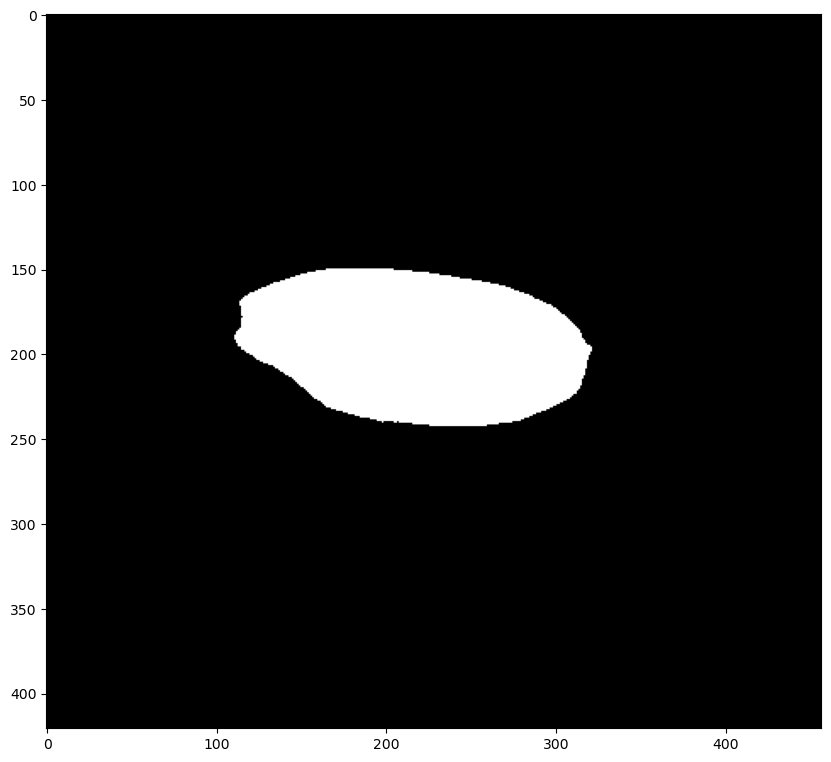

In [32]:
# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
mask = pcv.threshold.binary(gray_img=l, threshold=30, max_value=255, object_type='light')
#                                                          ^                                 ^
#                                                          |                                 |
#                                                  change this value                  change this value


# Section 3: Identify objects and Analyze Grain
* Requires a completed binary mask

## Identify seed objects for shape and color analysis
For shape and color analysis, we need to use find_objects from PlantCV to get the objects and object hierarchy that we need as inputs in the following analyses.

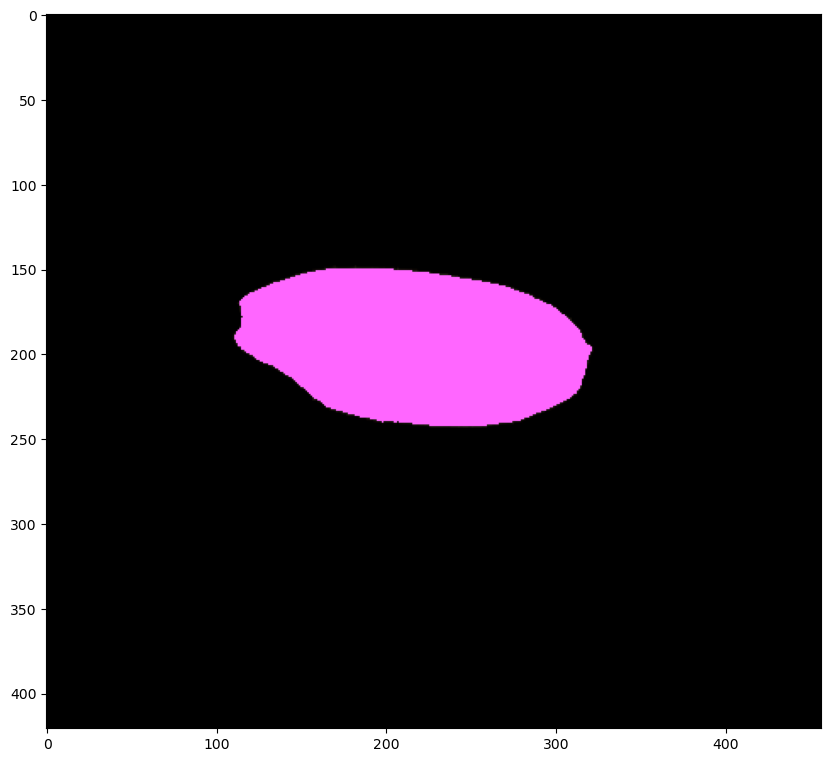

In [34]:
# Inputs:
#   img  = rgb image
#   mask = binary mask
obj, obj_hierarchy = pcv.find_objects(img=img, mask=mask)

## Create a new image isolating plant material

For calculating color values for the seed alone, we can create an image that isolated the grain alone, and excludes that background.

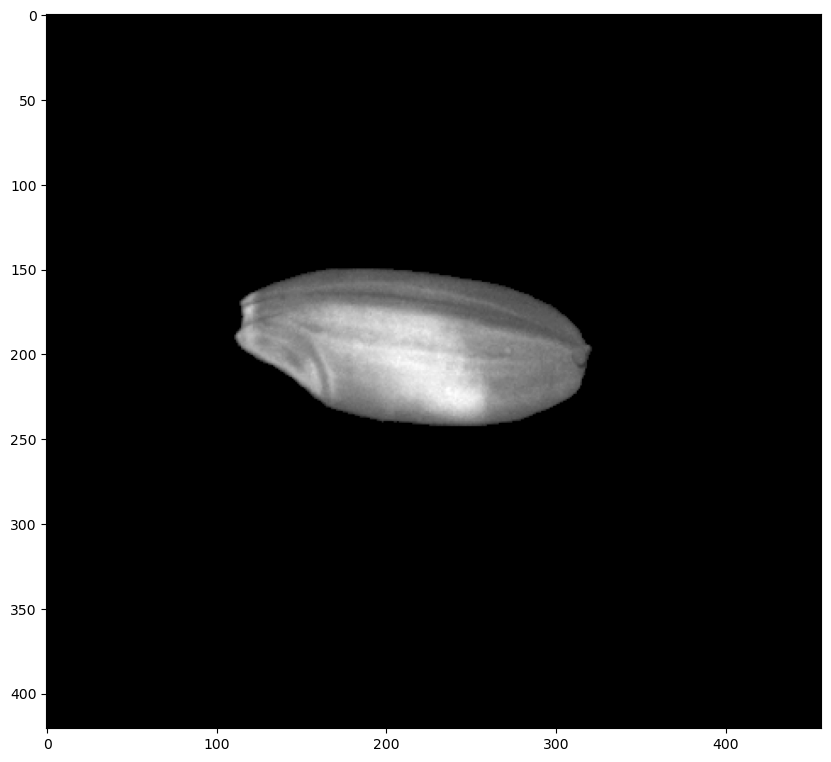

In [57]:
seed_img = pcv.apply_mask(img = l, mask = mask, mask_color="black")

## Calculate image intensity and chalkiness threshold

If chalkiness is a desired analysis, measure the median intensity and create an intensity threshold that will distinguish between pixels exhibiting chalkiness and those not.

In [68]:
# Inputs: 
#   a               = array of data
#   axis            = None (deafult) or int
#   out             = None (default) or ndarray
#   overwrite_input = False (default) or True
#   keepsdims       = False (default) or True
median_intensity = np.median(seed_img[np.where(seed_img > 0)])

chalk_threshold = median_intensity + 20

## Threshold chalky grain

Create a new binary threshold that only displays pixels that are at least as intense as the chalk threshold created in the previous step.

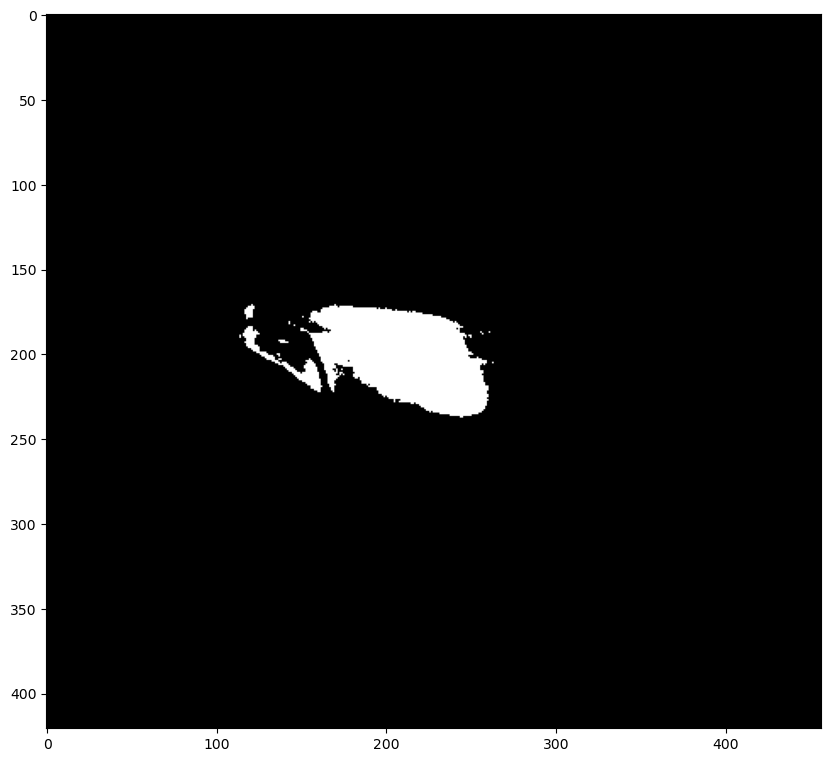

In [69]:
# Inputs:
#   gray_img    = black and white image created from selected colorspace
#   threshold   = cutoff pixel intensity value (all pixels below value will become black, all above will become white)
#   max_value   = maximum pixel value
#   object_type = 'dark' or 'light' depending on if seeds are darker or lighter than background
chalk = pcv.threshold.binary(gray_img=seed_img, threshold=chalk_threshold, max_value=255, object_type="light")
#                                                          ^                                 ^
#                                                          |                                 |
#                                                  change this value                  change this value

## Overlay chalkiness threshold to with original image

Overlay the chalkiness threshold with the original seed image, adding colors to help distinguish between differing areas within the grain.

First, create an array of zeros in the shape of the grain. Then, merge the weighted chalkiness threshold with the weighted grain image.

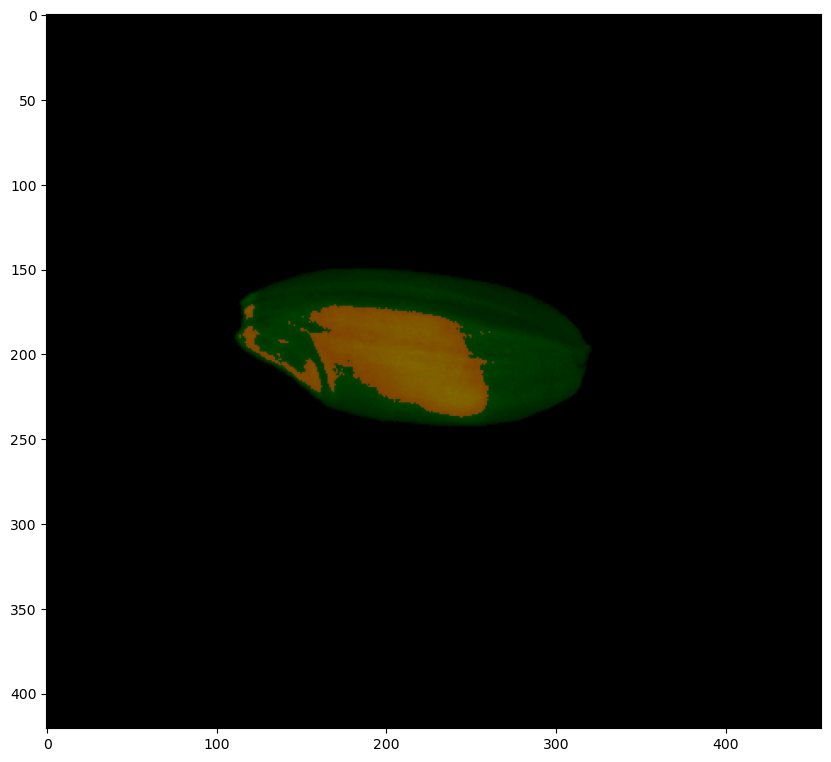

In [76]:
# Inputs: 
#   shape = int or tuple of ints
#   dtype = np.float64 (default) or data-type
#   order = 'C' (default) or 'F'
black = np.zeros(np.shape(l), dtype=np.uint8)

# Inputs:
#   src1  = first input array
#   alpha = weight of the first array elements
#   src2  = second input array, same size and channel number as src1
#   beta  = weight of second array elements
#   gamma = scalar added to each sum
#   dst   = output array
#   dtyle = depth of output array (optional)
overlaid = cv2.addWeighted(src2=cv2.merge([black, black, chalk]), alpha=0.5, 
                               src1=cv2.merge([black, seed_img, black]), beta=0.5, gamma=0)

pcv.plot_image(overlaid)

## Calculate ratio of chalkiness area to seed area

In [84]:
# Inputs:
#   a = array of data
#   axis = None (default)
#   keepdims = False (default)
chalky = np.count_nonzero(chalk)

# Inputs:
#   a = array of data
#   axis = None (default)
#   keepdims = False (default)
seedarea = np.count_nonzero(mask)

print(chalky)
print(seedarea)
print(chalky / seedarea)

5065
14934
0.33915896611758406


## Combine objects in plant
Objects may actually be multiple overlapping or layered objects, rather than just one. We need to combine objects so that one object, encapsulating the entire plant, can be passed to the image analysis function.

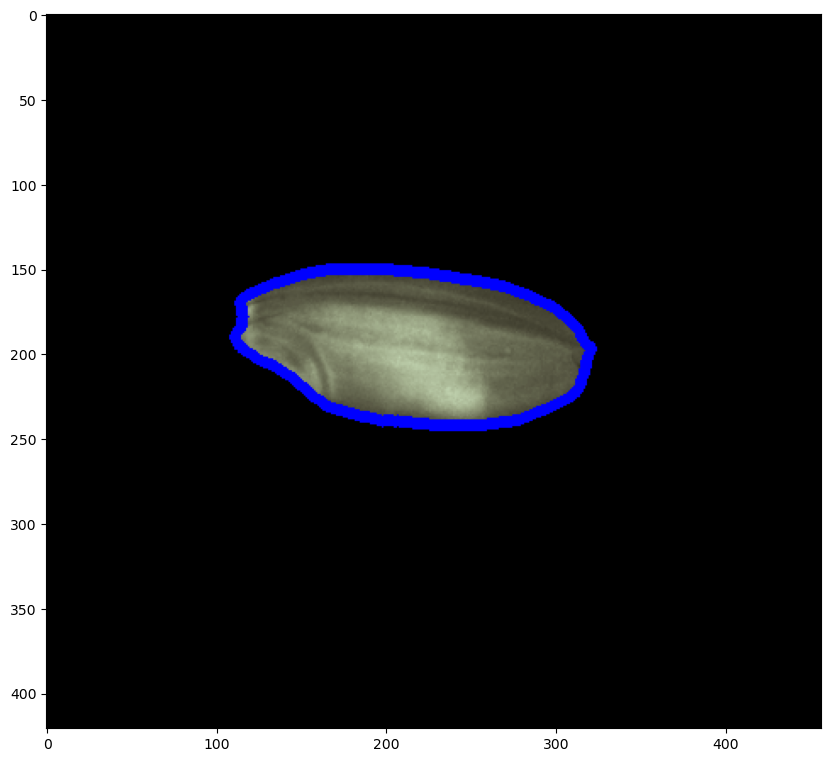

In [82]:
# Inputs:
#   img                = image
#   contours           = filtered plant contours from the roi_objects function
#   filtered_hierarchy = filtered plant contour hierarchy from the roi_objects function
seed_contour, seed_mask = pcv.object_composition(img=img, contours=objs, hierarchy=obj_hierarchy)

## Analyze grain shape

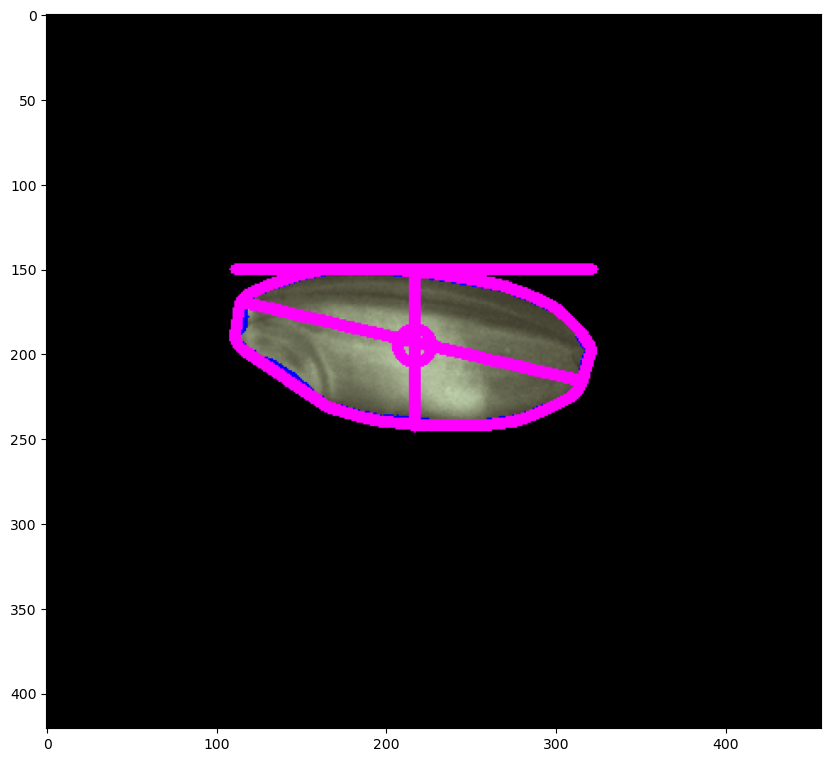

In [81]:
# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis  
#   label - Optional label parameter, modifies the variable name of observations recorded 
shape_img = pcv.analyze_object(img=img, obj=seed_contour, mask=seed_mask)

Save results
The save results function will take the measurements stored when running any PlantCV analysis functions, format, and print an output text file for data analysis. The Outputs class in this example will store 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', and 'ellipse_eccentricity' from the anayze_object function.

Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

In [22]:
# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format
pcv.outputs.save_results(filename=args.result)